In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# DOWNLOAD FILE LIBRARY

In [2]:
!pip3 install vncorenlp
!pip install -q tf-models-official

     |████████████████████████████████| 2.7MB 5.2MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-cp37-none-any.whl size=2645952 sha256=fea88da04c0492772672b9dbdf0e8c79cb178b0be7d81a0321587b2d88f3ddb8
  Stored in directory: /root/.cache/pip/wheels/09/54/8b/043667de6091d06a381d7745f44174504a9a4a56ecc9380c54
Successfully built vncorenlp
     |████████████████████████████████| 1.6MB 6.9MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 61kB 9.5MB/s 
     |████████████████████████████████| 215kB 52.6MB/s 
     |████████████████████████████████| 102kB 13.3MB/s 
     |████████████████████████████████| 358kB 50.5MB/s 
     |████████████████████████████████| 1.2MB 54.9MB/s 
     |████████████████████████████████| 38.2MB 72kB/s 
     |████████████████████████████████| 686kB 46.7MB/s 
     |████████████████████████████████| 645kB 49.8MB/s 


In [3]:
# !Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter) 
# !mkdir -p vncorenlp/models/wordsegmenter
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
# !mv VnCoreNLP-1.1.1.jar vncorenlp/ 
# !mv vi-vocab vncorenlp/models/wordsegmenter/
# !mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

# !mkdir -p pho2vec
# !wget https://public.vinai.io/word2vec_vi_words_300dims.zip
# !mv word2vec_vi_words_300dims.zip pho2vec/
# !unzip "./pho2vec/word2vec_vi_words_300dims.zip"

In [4]:
# annotator = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

# def preprocessing(row):
#   def tokenizer(row):
#     row = annotator.tokenize(row)
#     return ' '.join([' '.join(words) for words in row])
#   return tokenizer(row)

# IMPORT LIBRARY AND PATH DATASET

In [5]:
import pandas as pd
import numpy as np
import os
from vncorenlp import VnCoreNLP
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, Bidirectional, Dense, GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from official.nlp import optimization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.train import CheckpointOptions

np.random.seed(7)

In [6]:
path_root = '/content/drive/MyDrive/KTDLTT'
path_img = os.path.join(path_root, 'model/ViCTSD_construct/BiGRU/images')
MODEL_PATH = os.path.join(path_root, 'model/ViCTSD_construct/BiGRU')
name_model = 'ViCTSD_construct_BiGRU'


path_ViCTSD_train_toxic = os.path.join(path_root, 'data/UIT-ViCTSD/UIT-ViCTSD_train.csv')
path_ViCTSD_test_toxic = os.path.join(path_root, 'data/UIT-ViCTSD/UIT-ViCTSD_test.csv')
path_ViCTSD_dev_toxic = os.path.join(path_root, 'data/UIT-ViCTSD/UIT-ViCTSD_valid.csv')

# DATA LOADER AND PREPROCESSING

In [7]:
df_train = pd.read_csv(path_ViCTSD_train_toxic, encoding='utf-8').iloc[:, 1:]
df_test = pd.read_csv(path_ViCTSD_test_toxic, encoding='utf-8').iloc[:, 1:]
df_dev = pd.read_csv(path_ViCTSD_dev_toxic, encoding='utf-8').iloc[:, 1:]

In [8]:
df_train = df_train.astype({"Constructiveness": "int", "Toxicity": "int", 'Comment': "string"})
df_dev = df_dev.astype({"Constructiveness": "int", "Toxicity": "int", 'Comment': "string"})

In [9]:
annotator = VnCoreNLP(os.path.join(path_root, "src/vncorenlp/VnCoreNLP-1.1.1.jar"), annotators="wseg", max_heap_size='-Xmx500m') 

def preprocessing(row):
  def tokenizer(row):
    row = annotator.tokenize(row)
    return ' '.join([' '.join(words) for words in row])
  return tokenizer(row)

In [10]:
df_train.loc[:, 'Comment'] = df_train.loc[:, 'Comment'].apply(preprocessing)
df_test.loc[:, 'Comment'] = df_test.loc[:, 'Comment'].apply(preprocessing)
df_dev.loc[:, 'Comment'] = df_dev.loc[:, 'Comment'].apply(preprocessing)

In [11]:
df_train.head(5)

,Comment,Constructiveness,Toxicity,Title,Topic
0,Thật tuyệt_vời ... ! ! !,0,0,Những 'bước tiến diệu kỳ' của Trúc Nhi - Diệu Nhi,SucKhoe
1,"mỹ đã tuột_dốc quá nhiều rồi , giờ muốn vực dậ...",1,0,Hình tượng Mỹ sụp đổ trong lòng người dân thế ...,TheGioi
2,tôi thấy người lái_xe hơi bấm còi mới là người...,1,1,Cả trăm người đạp xe thể dục bịt kín đường,OtoXemay
3,Coi dịch là giặc . Đã mang tên đó mà xâm_nhập ...,0,0,11 ngày không lây nhiễm nCoV cộng đồng,SucKhoe
4,Thương các bé quá ! Các con còn quá nhỏ mà đã ...,0,0,5 trẻ chết đuối dưới ao,ThoiSu


In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Comment           7000 non-null   object
 1   Constructiveness  7000 non-null   int64 
 2   Toxicity          7000 non-null   int64 
 3   Title             7000 non-null   object
 4   Topic             7000 non-null   object
dtypes: int64(2), object(3)
memory usage: 273.6+ KB


In [13]:
# Load Pho2wv
# pho2wv = KeyedVectors.load_word2vec_format(os.path.join(path_root, 'src/word2vec_vi_words_300dims.txt'))

In [14]:
MAX_NB_WORDS = 75000
MAX_SEQUENCE_LENGTH = 128
DROPOUT = 0.5
nclasses = len(df_train['Constructiveness'].unique())
EMBEDDING_DIM = 300
BATCH_SIZE = 50
EPOCH = 10
lr = 1e-2
STEPS_PER_EPOCH = len(df_train['Comment']) // BATCH_SIZE
VALIDATION_STEPS = len(df_dev['Comment']) // BATCH_SIZE

In [15]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['Comment'])
word_index = tokenizer.word_index

In [16]:
def prepare_input(sents, tokenizer, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH):
  sequences = tokenizer.texts_to_sequences(sents)
  sents = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, truncating='post', padding='post')
  return sents

In [17]:
X_train = prepare_input(df_train['Comment'], tokenizer)
Y_train = np.array(df_train['Constructiveness'].tolist())

X_dev = prepare_input(df_dev['Comment'], tokenizer)
Y_dev = np.array(df_dev['Constructiveness'].tolist())

In [18]:
# Create embedding matrix 
# def create_embedding(EMBEDDING_DIM, word_index, embedding_dict):
#   embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
#   for word, i in word_index.items():
#     try:
#       embedding_vector = embedding_dict.get_vector(word)
#     except:
#       embedding_vector = None
#     if embedding_vector is not None:
#       if len(embedding_matrix[i]) != len(embedding_vector):
#         # words not found in embedding index will be all-zeros.
#           if len(embedding_matrix[i]) != len(embedding_vector):
#             print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
#                   "into shape", str(len(embedding_vector)), " Please make sure your"
#                                                             " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
#             exit(1)
#           embedding_matrix[i] = embedding_vector
#   return embedding_matrix
# embedding_matrix = create_embedding(EMBEDDING_DIM, word_index, embedding_dict=pho2wv)
# np.save(os.path.join(path_root, 'data/vector/pho2wv_ViCTSD.npy'), embedding_matrix)

In [19]:
# Load embedding matrix from file npy
embedding_matrix = np.load(os.path.join(path_root, 'data/vector/pho2wv_ViCTSD.npy'))

# Fine-tuning with TensorFlow

## Define the model

In [20]:
def create_model(word_index, embedding_matrix, optimizer, nclasses=nclasses, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH, EMBEDDING_DIM=EMBEDDING_DIM, dropout=DROPOUT, gru_node=32):
  model = Sequential()
  
  model.add(Embedding(len(word_index) + 1,
                      EMBEDDING_DIM,
                      weights=[embedding_matrix],
                      input_length=MAX_SEQUENCE_LENGTH,
                      trainable=True))
  
  model.add(Bidirectional(GRU(gru_node, return_sequences=True)))
  model.add(Bidirectional(GRU(gru_node)))
  model.add(Dropout(dropout))
  
  model.add(Dense(nclasses, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
  return model

## Optimizer

In [21]:
optimizer = 'adam'

## Callbacks

In [22]:
early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint_path = MODEL_PATH + '/checkpoints/cp-{epoch:03d}.ckpt'
# checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path, 
    save_weights_only = True,
    save_freq = 10 * STEPS_PER_EPOCH, 
    verbose = 1
)

## Training

In [23]:
model = create_model(word_index, embedding_matrix, optimizer, nclasses, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, DROPOUT, 128)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 128, 300)          2182200   
_________________________________________________________________
bidirectional (Bidirectional (None, 128, 256)          330240    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 514       
Total params: 2,809,402
Trainable params: 2,809,402
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(X_train, Y_train,
                              validation_data=(X_dev, Y_dev),
                              epochs=EPOCH,
                              batch_size=BATCH_SIZE,
                              callbacks = [
                                  early_stop_callback, 
                                  checkpoint_callback
                              ],
                              verbose=1)

Epoch 1/10
140/140 [==============================] - 20s 84ms/step - loss: 0.5493 - accuracy: 0.7314 - val_loss: 0.4562 - val_accuracy: 0.7775
Epoch 2/10
140/140 [==============================] - 11s 76ms/step - loss: 0.4504 - accuracy: 0.7886 - val_loss: 0.4384 - val_accuracy: 0.7780
Epoch 3/10
140/140 [==============================] - 10s 73ms/step - loss: 0.4029 - accuracy: 0.8190 - val_loss: 0.4254 - val_accuracy: 0.7955
Epoch 4/10
140/140 [==============================] - 10s 73ms/step - loss: 0.3544 - accuracy: 0.8450 - val_loss: 0.4251 - val_accuracy: 0.8010
Epoch 5/10
140/140 [==============================] - 11s 76ms/step - loss: 0.2869 - accuracy: 0.8789 - val_loss: 0.4518 - val_accuracy: 0.7965
Epoch 6/10
140/140 [==============================] - 11s 76ms/step - loss: 0.2314 - accuracy: 0.9076 - val_loss: 0.5069 - val_accuracy: 0.7750
Epoch 7/10
140/140 [==============================] - 11s 76ms/step - loss: 0.1751 - accuracy: 0.9321 - val_loss: 0.5500 - val_accuracy:

# Predict on test data

In [25]:
X_test = prepare_input(df_test['Comment'], tokenizer)
y_test = np.array(df_test['Constructiveness'].tolist())

In [26]:
print("\n Evaluating Model ... \n")
y_pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=1).argmax(axis=-1)
metric = metrics.classification_report(y_test, y_pred, output_dict=True)
print(metrics.classification_report(y_test, y_pred, digits=4))


 Evaluating Model ... 

20/20 [==============================] - 1s 20ms/step
              precision    recall  f1-score   support

           0     0.8440    0.8082    0.8257       636
           1     0.6880    0.7390    0.7126       364

    accuracy                         0.7830      1000
   macro avg     0.7660    0.7736    0.7691      1000
weighted avg     0.7872    0.7830    0.7845      1000



In [27]:
f1 = round(metric['macro avg']['f1-score'], 4)
name_model = name_model + '_' + str(lr).replace('.', '') + '_' + str(MAX_SEQUENCE_LENGTH) + '_' + str(BATCH_SIZE) + '_' + str(DROPOUT).replace('.', '') + '_' + str(f1).replace('.', '') + '.h5'
name_img_ = 'loss' + '_' + str(lr).replace('.', '') + '_' + str(MAX_SEQUENCE_LENGTH) + '_' + str(BATCH_SIZE) + '_' + str(DROPOUT).replace('.', '') + '_' + str(f1).replace('.', '') + '.png'
model.save_weights(os.path.join(MODEL_PATH, name_model))

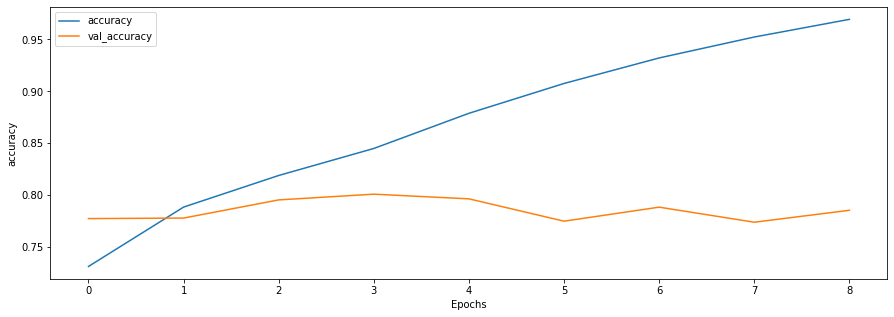

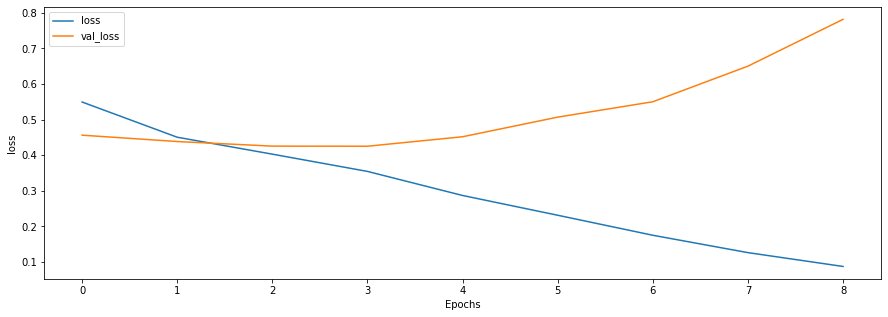

In [28]:
def plot_graphs(history, string):
  fig = plt.figure(figsize=(15, 5))
  name_img = string + '_' + str(lr).replace('.', '') + '_' + str(MAX_SEQUENCE_LENGTH) + '_' + str(BATCH_SIZE) + '_' + str(DROPOUT).replace('.', '') + '_' + str(f1).replace('.', '') + '.png'
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  fig.savefig(os.path.join(path_img, name_img), bbox_inches='tight') 
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

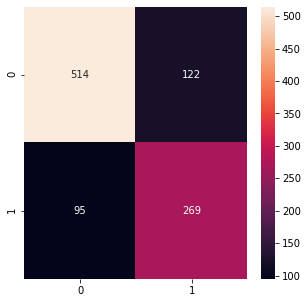

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def _confusion_matrix(Y_test, y_pred, metric, name_model, path_img=path_img):
  f1 = round(metric['macro avg']['f1-score'], 4)
  name_img = 'CM_' + name_model + '_' + str(f1).replace('.', '') + '.png' 
  cf_matrix = confusion_matrix(Y_test, y_pred)
  fig = plt.figure(figsize=(5, 5))
  sns.heatmap(cf_matrix, annot=True, fmt='g')
  sns.set(font_scale=1)
  fig.savefig(os.path.join(path_img, name_img), bbox_inches='tight')
  plt.show()

_confusion_matrix(y_test, y_pred, metric, name_model)